# 📘 Classifying Stack Overflow Posts using LSTM and GRU Models

This notebook explores the effectiveness of two popular Recurrent Neural Network (RNN) architectures—**LSTM (Long Short-Term Memory)** and **GRU (Gated Recurrent Unit)**—for a multi-class text classification task.

We aim to classify Stack Overflow post titles into three technical categories:
- **Spark**
- **Machine Learning (ML)**
- **Security**

---

## 🔄 Data Processing Pipeline

The full pipeline for handling and modeling the data is as follows:

1. **Dataset Loading**
   - Load Stack Overflow posts dataset (CSV format).
   - Each sample includes a title and its corresponding category label.

2. **Text Preprocessing**
   - Clean and normalize text (e.g., lowercasing, removing punctuation).
   - Tokenize text into words.
   - Remove out-of-vocabulary (OOV) tokens if necessary.

3. **Embedding with GloVe**
   - Use pre-trained **GloVe word embeddings (100d)** via `gensim.downloader`.
   - Convert each tokenized title into a sequence of vectors.

4. **Sequence Padding**
   - Pad sequences to a fixed length to ensure uniform input shape.

5. **Train/Test Split**
   - Split the dataset into training and testing sets while preserving class distribution.

6. **Model Definition**
   - Implement two neural models: one using **LSTM**, the other using **GRU** layers.
   - Each model ends with a fully connected layer for classification.

7. **Training**
   - Train both models on the training set using cross-entropy loss and an optimizer (e.g., Adam).
   - Monitor performance on the validation/test set during training.

8. **Evaluation**
   - Compute metrics such as accuracy, precision, recall, and F1-score.
   - Compare the results across models and categories.

-----------------------------------------------------------------------

##🔧 Installing Required Dependency
Before proceeding with the rest of the notebook, we need to install the gensim library, which is used for loading and working with pre-trained word embeddings such as Word2Vec or GloVe.

⚠️ Note: Run this cell only once, then restart the runtime (from the Runtime menu in Colab) before continuing with the rest of the notebook. This ensures all dependencies are properly loaded into memory.

In [ ]:
# Run it only one time, then restart the session and go one with the reminding cells
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 83.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 106.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 15.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
thinc 8.3.6 re

##📚 Library Imports & Setup
This cell loads all necessary libraries for data processing, modeling, and evaluation:

PyTorch: Model building and training

Pandas / NumPy: Data handling

Matplotlib / Seaborn: Visualization

Scikit-learn: Data splitting and evaluation

NLTK: Text preprocessing (stopwords, tokenization, lemmatization)

Gensim: Pre-trained word embeddings

In [ ]:
import pandas as pd
import warnings as wrn
wrn.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gensim.downloader as api
import kagglehub
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

##🔤 Loading GloVe Word Embeddings
This cell loads pre-trained GloVe embeddings using gensim.

We use the "glove-wiki-gigaword-100" model, which provides 100-dimensional vectors for a large vocabulary of English words.

embedding_dim is set to 100, matching the dimensionality of the GloVe vectors.

In [ ]:
# Load GloVe from gensim
glove_model = api.load("glove-wiki-gigaword-100")
embedding_dim = glove_model.vector_size  # 100

[==================================================] 100.0% 128.1/128.1MB downloaded


##📥 Loading the Dataset
This cell downloads and loads the StackOverflow Text Classification dataset:

Uses kagglehub to fetch the dataset from Kaggle.

Reads the CSV file containing labeled StackOverflow posts.

Displays the first few rows using df.head() to inspect the data.

In [ ]:
# Download and unzip the dataset
path = kagglehub.dataset_download("yazanalshuaibi/stackoverflow-text-classification")
df = pd.read_csv(f"{path}/stackoverflow_spark_ML_security.csv")
df.head()

100%|██████████| 5.06M/5.06M [00:01<00:00, 3.89MB/s]

Extracting files...


,Title,Label,Clean_Title
0,Different rlike behavior in Spark 1.6 and Spar...,spark,different rlike behavior spark spark
1,Getting a column as concatenated column from a...,spark,get column concatenate column reference table ...
2,Write data using JDBC connection to Azure SQL ...,spark,write data use jdbc connection azure sql db sc...
3,Get value from external client database for a ...,spark,get value external client database column valu...
4,How to setup Apache Spark to use local hard di...,spark,setup apache spark use local hard disk data fi...


##📊 Dataset Overview & Class Balance
This cell gives a high-level overview of the dataset:

Displays column names and data types

Shows how many samples belong to each category

Visualizes the category distribution using a bar chart

This helps detect class imbalance, which can affect model performance if not addressed.

📄 Dataset Summary:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Title        150000 non-null  object
 1   Label        150000 non-null  object
 2   Clean_Title  149999 non-null  object
dtypes: object(3)
memory usage: 3.4+ MB

🧠 Number of Samples per Category:

Label
spark       50000
ml          50000
security    50000
Name: count, dtype: int64



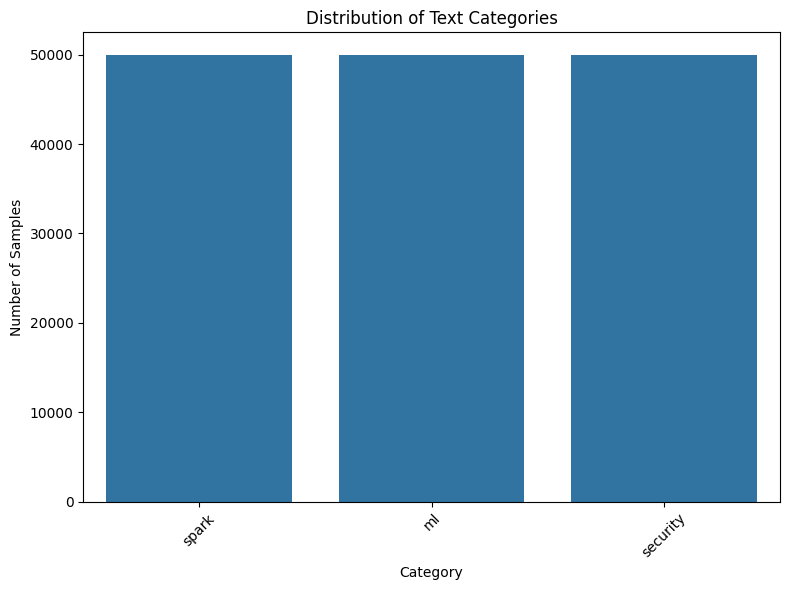

In [ ]:
# Display basic structure of the dataset
print("📄 Dataset Summary:\n")
df.info()

# Show how many samples exist for each category
print("\n🧠 Number of Samples per Category:\n")
print(df['Label'].value_counts())
print("=======================================\n")
# Plot distribution of categories
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='Label', order=df['Label'].value_counts().index)
plt.title('Distribution of Text Categories')
plt.xlabel('Category')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


##✍️ Title Length Analysis (Word Count)
In this cell, we analyze the number of words in each text title. This is crucial because NLP models like RNNs and LSTMs operate on sequences of tokens (words), not characters.


 * Calculate the average, minimum, and maximum word count.
 * Visualize the distribution using a histogram.
 * This helps us choose an appropriate sequence length during preprocessing.

📝 Average Word Count: 9.20
🔢 Max Word Count: 32
🔢 Min Word Count: 1


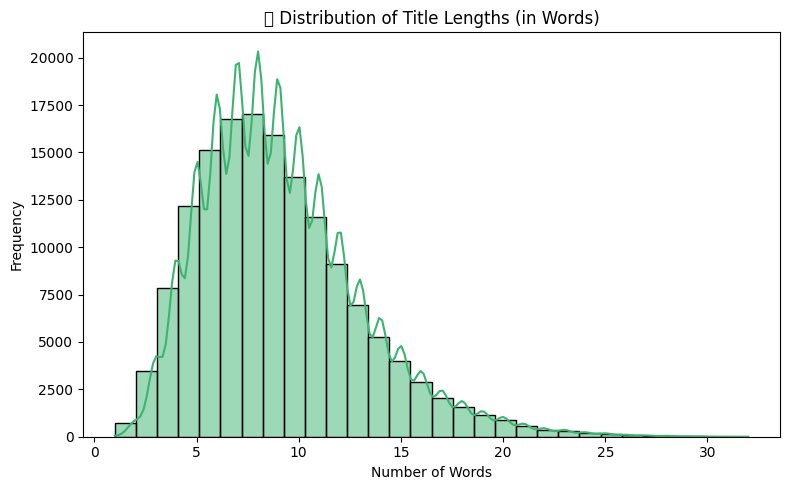

In [ ]:
# Compute word count for each title
word_counts = df['Title'].apply(lambda x: len(x.split()))

# Summary statistics
print(f"📝 Average Word Count: {word_counts.mean():.2f}")
print(f"🔢 Max Word Count: {word_counts.max()}")
print(f"🔢 Min Word Count: {word_counts.min()}")

# Plot word count distribution
plt.figure(figsize=(8, 5))
sns.histplot(word_counts, bins=30, kde=True, color='mediumseagreen')
plt.title('📊 Distribution of Title Lengths (in Words)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


##🔍 Example Titles by Category
To better understand the nature of the text in each category, this cell prints a sample title from each label in the dataset.

This helps us:

 * Inspect the kind of questions or issues discussed

 * Spot common patterns in phrasing or keywords

 * Prepare for later steps in preprocessing and modeling



In [ ]:
# ✅ Define the list of unique labels
unique_labels = df['Label'].unique()

for label in unique_labels:
    print(f"📚 Samples from '{label}':")
    samples = df[df['Label'] == label]['Title'].head(3)
    for i, sample in enumerate(samples, 1):
        print(f"  {i}. {sample}")
    print("-" * 60)

📚 Samples from 'spark':
  1. Different rlike behavior in Spark 1.6 and Spark 2.2
  2. Getting a column as concatenated column from a reference table and primary id's from a Dataset
  3. Write data using JDBC connection to Azure SQL DB with Scala code Databricks notebook
------------------------------------------------------------
📚 Samples from 'ml':
  1. How to setup Apache Spark to use local hard disk when data does not fit in RAM in local mode?
  2. How to solve these problems about inverted ROC curve, small AUC, and the cutoff?
  3. PyTorch does not converge when approximating square function with linear model
------------------------------------------------------------
📚 Samples from 'security':
  1. How do I call a Flex SWF from a remote domain using Flash (AS3)?
  2. AES256 Encryption/Decryption Error+ IOS SDK 7
  3. How to retrieve a file from a server via SFTP?
------------------------------------------------------------


##📦 Text Preprocessing Class
This class provides a way to clean and tokenize text data. It performs the following steps:

Lowercases the text
* Removes punctuation and numbers
* Tokenizes the text into words
* Removes common stopwords
* Lemmatizes each word (e.g., “running” → “run”)

In [ ]:
class TextPreprocessor:
    """
    A simple text cleaner that lowercases, removes punctuation,
    tokenizes, removes stopwords, and lemmatizes.
    """
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))

    def preprocess(self, text):
        text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove punctuation/numbers
        # text = text.lower()                      # Lowercase
        tokens = word_tokenize(text)             # Tokenize
        tokens = [t for t in tokens if t not in self.stop_words]  # Remove stopwords
        # tokens = [self.lemmatizer.lemmatize(t) for t in tokens]   # Lemmatize
        return tokens

preprocessor = TextPreprocessor()


In [ ]:
# Apply preprocessing using the .preprocess() method
df['Clean_Title'] = df['Title'].apply(preprocessor.preprocess)

In [ ]:
df.head()

,Title,Label,Clean_Title,Vectorized_Title
0,Different rlike behavior in Spark 1.6 and Spar...,spark,"[Different, rlike, behavior, Spark, Spark]","[[tensor(-0.3419), tensor(0.6998), tensor(-0.0..."
1,Getting a column as concatenated column from a...,spark,"[Getting, column, concatenated, column, refere...","[[tensor(0.4009), tensor(0.1964), tensor(0.685..."
2,Write data using JDBC connection to Azure SQL ...,spark,"[Write, data, using, JDBC, connection, Azure, ...","[[tensor(-0.5106), tensor(0.4867), tensor(-0.0..."
3,Get value from external client database for a ...,spark,"[Get, value, external, client, database, colum...","[[tensor(0.1443), tensor(0.4395), tensor(0.583..."
4,How to setup Apache Spark to use local hard di...,spark,"[How, setup, Apache, Spark, use, local, hard, ...","[[tensor(-0.2377), tensor(0.5939), tensor(0.58..."


#Word Embedding with GloVe
In this step, we convert each cleaned title into a sequence of word embeddings using the pre-trained GloVe model:

##🔍 How It Works:
For each token in a cleaned title:

 * If the token exists in GloVe, we use its vector.
 * If not, we use a zero vector (to handle unknown words).
 * Each title is now represented as a tensor of shape (sequence length × embedding dimension).

##🧠 Why This Matters:
This transforms the raw text into a numerical format that can be fed into deep learning models like RNNs or LSTMs.

In [ ]:
def vectorize_text(tokens, embeddings, embedding_dim):
    vectors = []
    for token in tokens:
        if token in embeddings:
            vectors.append(torch.tensor(embeddings[token]))
        else:
            vectors.append(torch.zeros(embedding_dim))  # unknown token
    return torch.stack(vectors) if vectors else torch.zeros((0, embedding_dim))


# Add a new column 'Vectorized_Title' to the DataFrame, containing the vectorized form of 'Clean_Title'
df['Vectorized_Title'] = df['Clean_Title'].apply(lambda x: vectorize_text(x, glove_model, embedding_dim))


In [ ]:
df.head()

,Title,Label,Clean_Title,Vectorized_Title
0,Different rlike behavior in Spark 1.6 and Spar...,spark,"[different, rlike, behavior, in, spark, and, s...","[[tensor(-0.3419), tensor(0.6998), tensor(-0.0..."
1,Getting a column as concatenated column from a...,spark,"[getting, a, column, as, concatenated, column,...","[[tensor(0.4009), tensor(0.1964), tensor(0.685..."
2,Write data using JDBC connection to Azure SQL ...,spark,"[write, data, using, jdbc, connection, to, azu...","[[tensor(-0.5106), tensor(0.4867), tensor(-0.0..."
3,Get value from external client database for a ...,spark,"[get, value, from, external, client, database,...","[[tensor(0.1443), tensor(0.4395), tensor(0.583..."
4,How to setup Apache Spark to use local hard di...,spark,"[how, to, setup, apache, spark, to, use, local...","[[tensor(-0.2377), tensor(0.5939), tensor(0.58..."


In [ ]:
# Check the shape of the first vector to ensure it is a 100-dimensional vector according to the GloVe embeddings
df['Vectorized_Title'][0].shape

torch.Size([7, 100])

##🧼 Removing Empty Vectorized Samples
Some titles may be completely made up of unknown or removed tokens (e.g., stopwords or rare words), which results in empty tensors during vectorization.

This step filters out those cases by keeping only rows where Vectorized_Title is non-empty.

In [ ]:
# Filter out all rows that have empty tensors
df = df[df["Vectorized_Title"].apply(lambda x: len(x) > 0)]

##🧪 Splitting the Dataset (Train / Validation / Test)
To evaluate our model properly, we split the dataset into three parts:

* Train Set (60%) — used to train the model

* Validation Set (20%) — used to tune model hyperparameters

* Test Set (20%) — used to evaluate final model performance

##📌 Notes:
* Splits are stratified by label, meaning the class distribution is preserved across all sets.

* This helps ensure that each subset is representative of the original dataset.

In [ ]:
# Split the dataset into train and test sets with an 80/20 split, stratified by the 'Label' column
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Label'])

# Split the train dataset into train and validation sets with an 80/20 split, stratified by the 'Label' column
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42, stratify=train_df['Label'])

##📊 Visualizing Label Distribution in Train/Val/Test Splits

This plot helps verify that the class distribution is preserved across all three dataset splits:

* Ensures fairness in training and evaluation
* Confirms that stratified splitting worked as expected
* Useful for spotting imbalances early on

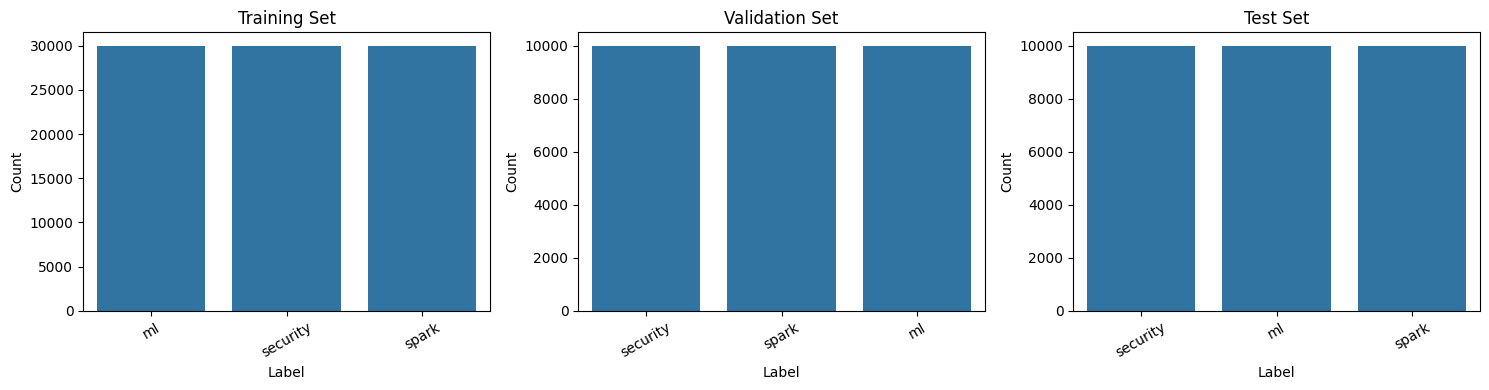

In [ ]:
# Plot label distributions for train, val, and test sets
def plot_label_distributions(datasets, titles):
    plt.figure(figsize=(15, 4))
    for i, (df, title) in enumerate(zip(datasets, titles), 1):
        plt.subplot(1, 3, i)
        sns.countplot(x='Label', data=df, order=df['Label'].value_counts().index)
        plt.title(title)
        plt.xlabel('Label')
        plt.ylabel('Count')
        plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

# Call the function
plot_label_distributions(
    [train_df, val_df, test_df],
    ['Training Set', 'Validation Set', 'Test Set']
)


##📦 Custom PyTorch Dataset & Collate Function
This cell defines two key components for handling our vectorized text data in PyTorch:

##🗂️ StackOverflowDataset
A custom Dataset class that:

* Loads each sample from the DataFrame
* Converts the vectorized title to a tensor
* Maps the text label to a numeric index

##🧱 collate_batch
A custom collate function used by the DataLoader to:

* Pad each sequence in a batch to the same length
* Stack them into a single tensor for training

✅ This is important for feeding variable-length sequences into RNN-based models in mini-batches.

In [ ]:
class StackOverflowDataset(Dataset):
    """
    Custom PyTorch Dataset for StackOverflow vectorized titles.
    """
    def __init__(self, df, label_to_idx):
        self.df = df
        self.label_to_idx = label_to_idx

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        text = torch.stack(list(self.df.iloc[idx]["Vectorized_Title"]))
        label = torch.tensor(self.label_to_idx[self.df.iloc[idx]["Label"]], dtype=torch.long)
        return text, label


def collate_batch(batch):
    """
    Pads sequences in a batch to the same length.
    """
    texts, labels = zip(*batch)
    max_len = max(len(text) for text in texts)
    padded_texts = [torch.cat([text, torch.zeros(max_len - len(text), 100)]) for text in texts]
    return torch.stack(padded_texts), torch.tensor(labels, dtype=torch.long)


#🧠 RNN-Based Classifiers: LSTM, GRU, and RNN
This cell defines three custom PyTorch models for text classification, each using a different recurrent architecture:

##🔁 LSTMClassifier
Uses a Long Short-Term Memory (LSTM) layer to handle long-term dependencies.

##🔁 GRUClassifier
Similar to LSTM, but uses Gated Recurrent Units (GRU), which are simpler and often faster.

##🔁 RNNClassifier
Uses a standard vanilla RNN layer.

Good for understanding baseline performance, but usually less effective than LSTM/GRU for complex sequences.



> All models take a sequence of word embeddings as input and output logits for class prediction.





In [ ]:
class LSTMClassifier(nn.Module):
    """
    A custom LSTM-based classifier for text classification.
    """
    def __init__(self, embed_dim, hidden_dim, num_classes, dropout=0.5):
        """
        Initializes a new LSTMClassifier object.

        Args:
        embed_dim (int): the dimension of the word embeddings
        hidden_dim (int): the size of the hidden state in the LSTM layer
        num_classes (int): the number of classes in the classification task
        dropout (float, optional): the dropout probability (default: 0.5)
        """
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        """
        Defines the forward pass for the LSTMClassifier.

        Args:
        text (torch.Tensor): the input text tensor

        Returns:
        torch.Tensor: the logits for the classification task
        """
        lstm_out, _ = self.lstm(text)
        pooled = self.dropout(torch.mean(lstm_out, dim=1))
        logits = self.fc(pooled)
        return logits

class GRUClassifier(nn.Module):
    """
    A custom GRU-based classifier for text classification.
    """
    def __init__(self, embed_dim, hidden_dim, num_classes, dropout=0.5):
        """
        Initializes a new GRUClassifier object.

        Args:
        embed_dim (int): the dimension of the word embeddings
        hidden_dim (int): the size of the hidden state in the GRU layer
        num_classes (int): the number of classes in the classification task
        dropout (float, optional): the dropout probability (default: 0.5)
        """
        super(GRUClassifier, self).__init__()
        self.gru = nn.GRU(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        """
        Defines the forward pass for the GRUClassifier.

        Args:
        text (torch.Tensor): the input text tensor

        Returns:
        torch.Tensor: the logits for the classification task
        """
        gru_out, _ = self.gru(text)
        pooled = self.dropout(torch.mean(gru_out, dim=1))
        logits = self.fc(pooled)
        return logits

class RNNClassifier(nn.Module):
    """
    A custom RNN-based classifier for text classification.
    """
    def __init__(self, embed_dim, hidden_dim, num_classes, dropout=0.5):
        super(RNNClassifier, self).__init__()
        self.rnn = nn.RNN(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        rnn_out, _ = self.rnn(text)
        pooled = self.dropout(torch.mean(rnn_out, dim=1))
        logits = self.fc(pooled)
        return logits

##📥 Preparing DataLoaders for Model Training
This cell handles the final preparation of the data before training:

##🗂️ Label Encoding
A dictionary label_to_idx maps each category name ("spark", "ml", "security") to a unique index.

##📦 Dataset Initialization
Creates instances of StackOverflowDataset for the train, validation, and test splits.

##🚚 DataLoader Setup

* Wraps each dataset in a DataLoader with:
* A defined batch_size (64)
* Shuffling for the training set only
* A custom collate_fn to pad sequences within each batch

In [ ]:
# Create a dictionary to map labels to their corresponding index values
label_to_idx = {"spark": 0, "ml": 1, "security": 2}

# Initialize the StackOverflowDataset objects for training, validation, and testing
train_dataset = StackOverflowDataset(train_df, label_to_idx)
val_dataset = StackOverflowDataset(val_df, label_to_idx)
test_dataset = StackOverflowDataset(test_df, label_to_idx)

# Set the batch size for data loading
batch_size = 64

# Initialize DataLoaders for training, validation, and testing
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

##🧪 Training with Accuracy Tracking
This function trains the model and now logs both:

* Loss and accuracy on the training set
* Loss and accuracy on the validation set
* This helps monitor learning progress and overfitting during training.

In [ ]:
def train_and_evaluate(model, num_epochs=10):
    """
    Trains a model, tracks loss and accuracy on train/val sets,
    and returns test predictions.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    optimizer = optim.AdamW(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        # --- Training ---
        model.train()
        train_loss, correct_train, total_train = 0, 0, 0
        for texts, labels in train_dataloader:
            texts, labels = texts.to(device), labels.to(device)
            optimizer.zero_grad()
            logits = model(texts)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        # --- Validation ---
        model.eval()
        val_loss, correct_val, total_val = 0, 0, 0
        with torch.no_grad():
            for texts, labels in val_dataloader:
                texts, labels = texts.to(device), labels.to(device)
                logits = model(texts)
                loss = criterion(logits, labels)
                val_loss += loss.item()

                preds = torch.argmax(logits, dim=1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

        # --- Logging ---
        avg_train_loss = train_loss / len(train_dataloader)
        avg_val_loss = val_loss / len(val_dataloader)
        train_acc = correct_train / total_train
        val_acc = correct_val / total_val
        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

    # --- Testing ---
    model.eval()
    true_labels, pred_labels = [], []
    with torch.no_grad():
        for texts, labels in test_dataloader:
            texts, labels = texts.to(device), labels.to(device)
            logits = model(texts)
            predictions = torch.argmax(logits, dim=1)
            true_labels.extend(labels.tolist())
            pred_labels.extend(predictions.tolist())

    return true_labels, pred_labels


##🤖 Model Training: LSTM vs GRU vs RNN
In this cell, we initialize and train three different recurrent neural network classifiers

![Architecture](https://raw.githubusercontent.com/VictorCeballos/KAUST-AI-SS/64caff9fffd9e2e9404277c3c0503c5e8a5420df/Week%205%20-%20Natural%20Language%20Processing/Labs/Day8/archs.png)


In [ ]:
# Model configuration
embed_dim = 100       # From GloVe vectors
hidden_dim = 128      # Hidden size for RNN layers
num_classes = 3       # Number of output categories

# LSTM Model
lstm_model = LSTMClassifier(embed_dim, hidden_dim, num_classes)
print("📘 Training and evaluating LSTM model:")
lstm_true_labels, lstm_pred_labels = train_and_evaluate(lstm_model)

# GRU Model
gru_model = GRUClassifier(embed_dim, hidden_dim, num_classes)
print("\n📘 Training and evaluating GRU model:")
gru_true_labels, gru_pred_labels = train_and_evaluate(gru_model)

# RNN Model
rnn_model = RNNClassifier(embed_dim, hidden_dim, num_classes)
print("\n📘 Training and evaluating RNN model:")
rnn_true_labels, rnn_pred_labels = train_and_evaluate(rnn_model)


📘 Training and evaluating LSTM model:
Epoch 1/10 | Train Loss: 0.4134 | Train Acc: 0.8391 | Val Loss: 0.3095 | Val Acc: 0.8845
Epoch 2/10 | Train Loss: 0.2864 | Train Acc: 0.8923 | Val Loss: 0.2640 | Val Acc: 0.9010
Epoch 3/10 | Train Loss: 0.2486 | Train Acc: 0.9059 | Val Loss: 0.2641 | Val Acc: 0.8948
Epoch 4/10 | Train Loss: 0.2261 | Train Acc: 0.9152 | Val Loss: 0.2381 | Val Acc: 0.9128
Epoch 5/10 | Train Loss: 0.2081 | Train Acc: 0.9224 | Val Loss: 0.2323 | Val Acc: 0.9138
Epoch 6/10 | Train Loss: 0.1938 | Train Acc: 0.9278 | Val Loss: 0.2348 | Val Acc: 0.9109
Epoch 7/10 | Train Loss: 0.1803 | Train Acc: 0.9328 | Val Loss: 0.2491 | Val Acc: 0.9113
Epoch 8/10 | Train Loss: 0.1698 | Train Acc: 0.9367 | Val Loss: 0.2360 | Val Acc: 0.9120
Epoch 9/10 | Train Loss: 0.1573 | Train Acc: 0.9414 | Val Loss: 0.2314 | Val Acc: 0.9161
Epoch 10/10 | Train Loss: 0.1464 | Train Acc: 0.9456 | Val Loss: 0.2556 | Val Acc: 0.9152

📘 Training and evaluating GRU model:
Epoch 1/10 | Train Loss: 0.3790 |

##🧾 Classification Reports: LSTM vs GRU vs RNN
This cell prints the performance metrics of each model using classification_report from sklearn.

In [ ]:
print("LSTM Model Performance:")
print(classification_report(lstm_true_labels, lstm_pred_labels, target_names=list(label_to_idx.keys()), digits=4))


print("GRU Model Performance:")
print(classification_report(gru_true_labels, gru_pred_labels, target_names=list(label_to_idx.keys()), digits=4))

print("RNN Model Performance:")
print(classification_report(rnn_true_labels, rnn_pred_labels, target_names=list(label_to_idx.keys()), digits=4))

LSTM Model Performance:
              precision    recall  f1-score   support

       spark     0.9177    0.8955    0.9065     10000
          ml     0.9038    0.9108    0.9073     10000
    security     0.9304    0.9458    0.9381     10000

    accuracy                         0.9174     30000
   macro avg     0.9173    0.9174    0.9173     30000
weighted avg     0.9173    0.9174    0.9173     30000

GRU Model Performance:
              precision    recall  f1-score   support

       spark     0.8722    0.9217    0.8963     10000
          ml     0.9225    0.8675    0.8941     10000
    security     0.9332    0.9359    0.9345     10000

    accuracy                         0.9084     30000
   macro avg     0.9093    0.9084    0.9083     30000
weighted avg     0.9093    0.9084    0.9083     30000

RNN Model Performance:
              precision    recall  f1-score   support

       spark     0.8072    0.9346    0.8662     10000
          ml     0.9132    0.8259    0.8674     10000
    s

##🔍 Confusion Matrices: LSTM vs GRU vs RNN
This visualization shows how each model performs on the test set in terms of true vs. predicted labels:

* Helps identify where each model struggles (e.g., confusing one class with another)

* Useful for error analysis and model comparison

In [ ]:
def plot_confusion_matrices(true_labels, lstm_preds, gru_preds, rnn_preds):
    """
    Plots confusion matrices for LSTM, GRU, and RNN classifiers.
    """
    preds = [lstm_preds, gru_preds, rnn_preds]
    titles = ['LSTM', 'GRU', 'RNN']
    labels = list(label_to_idx.keys())

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    for ax, pred, title in zip(axes, preds, titles):
        cm = confusion_matrix(true_labels, pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                    xticklabels=labels, yticklabels=labels)
        ax.set_title(f"{title} Confusion Matrix")
        ax.set_xlabel("Predicted")
        ax.set_ylabel("True")

    plt.tight_layout()
    plt.show()


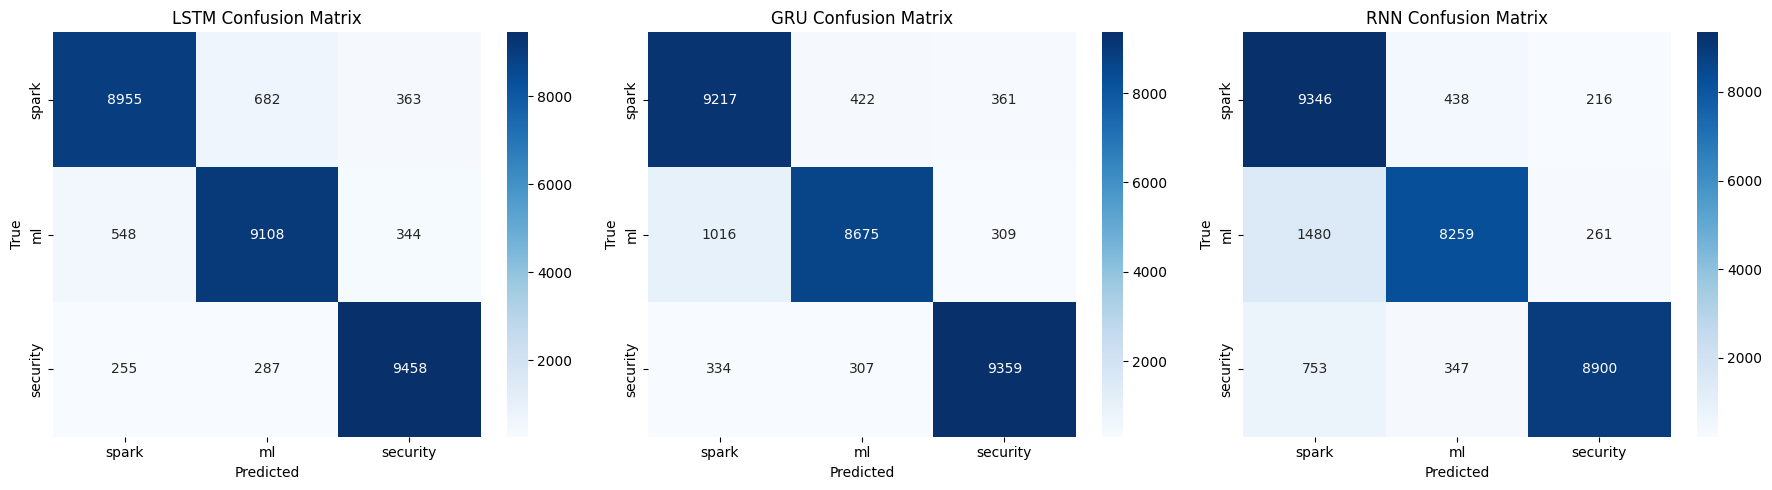

In [ ]:
plot_confusion_matrices(lstm_true_labels, lstm_pred_labels, gru_pred_labels, rnn_pred_labels)

## Contirbuted by: Yazan Alshoibi
adapted from: [RNNs to classify Stack Overflow posts using PyTorch -
jashdubal](https://github.com/jashdubal/stackoverflow-classifier)

##🧠 Exercises
To deepen your understanding and improve model performance, try implementing the following:

##🔧 1. Hyperparameter Tuning
Experiment with different:

* Learning rates (e.g., 0.001, 0.0005, 0.0001)

* Optimizers (Adam, AdamW, SGD)

* Batch sizes (16, 32, 64)

* Number of epochs

* Plot training/validation loss and accuracy for each run to find the optimal combination.

##🧼 2. Try Different Preprocessing Techniques
Test the impact of:

* Lowercasing all text

* Removing stopwords

* Stemming vs. Lemmatization

* Removing rare words or frequent tokens (e.g., punctuation, digits)

* Re-evaluate model performance after each preprocessing change.

##🏗️ 3. Add More Layers
Add depth to your model:

* Use stacked RNN/LSTM/GRU layers (e.g., num_layers=2 or 3)

* Apply dropout between layers to prevent overfitting

* Compare the results with your single-layer architecture.